In [64]:
# Imports
import os
import h5py
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Global variables
train_dir = 'svhn_train_data'
test_dir = 'svhn_test_data'
extra_dir = 'svhn_extra_data'

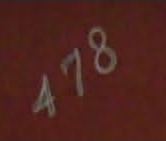

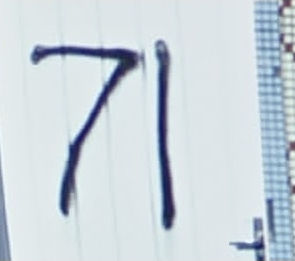

In [79]:
# First two images
display.display(display.Image(extra_dir + '/' + str(1) + '.png'), display.Image(extra_dir + '/' + str(2) + '.png'))

In [68]:
# Extract data and convert to numpy arrays
train_num = 225000
img_size = 64
channels_num = 1
labels_num = 11
digits_num = 5

# Get metadata
def extract_metadata(dr):
    metadata = {}
    fl = h5py.File(dr + '/digitStruct.mat')
    
    for i in xrange(len([x for x in os.listdir(dr) if x.split('.')[1] == 'png'])):        
        name = fl['digitStruct']['name'][i][0]
        bbox = fl['digitStruct']['bbox'][i][0]
        image_metadata = []
    
        if len(fl[bbox]['label']) == 1:    
            digit_metadata = {}
            digit_metadata['height'] = fl[bbox]['height'][0][0]
            digit_metadata['width'] = fl[bbox]['width'][0][0]
            digit_metadata['top'] = fl[bbox]['top'][0][0]
            digit_metadata['left'] = fl[bbox]['left'][0][0]
            digit_metadata['label'] = fl[bbox]['label'][0][0]
            image_metadata.append(digit_metadata)                    
        else:
            for j in xrange(len(fl[bbox]['label'])):
                digit_metadata = {}
                digit_metadata['height'] = [x for x in fl[fl[bbox]['height'][j][0]]][0][0]
                digit_metadata['width'] = [x for x in fl[fl[bbox]['width'][j][0]]][0][0]
                digit_metadata['top'] = [x for x in fl[fl[bbox]['top'][j][0]]][0][0]
                digit_metadata['left'] = [x for x in fl[fl[bbox]['left'][j][0]]][0][0]
                digit_metadata['label'] = [x for x in fl[fl[bbox]['label'][j][0]]][0][0]
                image_metadata.append(digit_metadata)                    
        
        metadata[''.join(chr(c) for c in fl[name][:])] = image_metadata
    
    return metadata

train_metadata = extract_metadata(train_dir)
test_metadata = extract_metadata(test_dir)
extra_metadata = extract_metadata(extra_dir)

# 29930.png is the only image with more than 5 digits, so we will treat it as an outlier and remove it
display.display(display.Image(train_dir + '/' + str(29930) + '.png'))
if '29930.png' in train_metadata:
    del train_metadata['29930.png']
    
# # Open images, convert to grayscale, resize, convert to numpy, and normalize
# train_X = np.ndarray((train_num, img_size, img_size, channels_num)).astype(np.float32)
# train_y = np.ndarray((train_num, digits_num, labels_num))
# valid_X = np.ndarray((len(train_metadata) - train_num, img_size, img_size, channels_num)).astype(np.float32)
# valid_y = np.ndarray((len(train_metadata) - train_num, digits_num, labels_num))
# test_X = np.ndarray((len(test_metadata), img_size, img_size, channels_num)).astype(np.float32)
# test_y = np.ndarray((len(test_metadata), digits_num, labels_num))

# def img_to_np(img):
#     img_gray = img.convert('L')
#     img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
#     img_np = np.array(img_resized)
#     img_normal = (img_np - (255.0 / 2.0)) / 255.0
#     return img_normal.reshape((img_size, img_size, channels_num))

# # Training
# for i in xrange(1, len(train_X) + 1):
#     train_X[i - 1,:,:,:] = img_to_np(Image.open(train_dir + '/' + str(i) + '.png'))
    
#     for j in xrange(digits_num):
#         if j < len(train_metadata[str(i) + '.png']):
#             label = train_metadata[str(i) + '.png'][j]['label']
#             train_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
#         else:
#             train_y[i - 1,j,:] = np.arange(labels_num) == 10
    
# # Validation
# for i in xrange(len(valid_X) + 1):
#     if i != 4929:  # Account for outlier
#         index = i if i < 4929 else i - 1
#         valid_X[index,:,:,:] = img_to_np(Image.open(train_dir + '/' + str(i + len(train_X) + 1) + '.png'))

#         for j in xrange(digits_num):
#             if j < len(train_metadata[str(i + len(train_X) + 1) + '.png']):
#                 label = train_metadata[str(i + len(train_X) + 1) + '.png'][j]['label']
#                 index = i if i < 4929 else i - 1
#                 valid_y[index,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
#             else:
#                 valid_y[index,j,:] = np.arange(labels_num) == 10

# # Testing
# for i in xrange(1, len(test_X) + 1):
#     test_X[i - 1,:,:,:] = img_to_np(Image.open(test_dir + '/' + str(i) + '.png'))
    
#     for j in xrange(digits_num):
#         if j < len(test_metadata[str(i) + '.png']):
#             label = test_metadata[str(i) + '.png'][j]['label']
#             test_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
#         else:
#             test_y[i - 1,j,:] = np.arange(labels_num) == 10
            
# # Make sure we preprocessed correctly
# print('Training data shape: %s' % str(train_X.shape))
# print('Training labels shape: %s' % str(train_y.shape))
# print('Validation data shape: %s' % str(valid_X.shape))
# print('Validation labels shape: %s' % str(valid_y.shape))
# print('Testing data shape: %s' % str(test_X.shape))
# print('Testing labels shape: %s\n' % str(test_X.shape))

# print('Digits per image in training set:')
# for n in xrange(1, 7):
#     print('%d images with %d digits' % (len([5 - len([x for x in train_y[i,:,10] if x == 1]) for i in xrange(1) if 
#                                              5 - len([x for x in train_y[i,:,10] if x == 1]) == n]), n))

In [77]:
# Open images, convert to grayscale, resize, convert to numpy, and normalize
train_X = np.ndarray((len(extra_metadata), img_size, img_size, channels_num)).astype(np.float32)
train_y = np.ndarray((len(extra_metadata), digits_num, labels_num))
valid_X = np.ndarray((len(train_metadata), img_size, img_size, channels_num)).astype(np.float32)
valid_y = np.ndarray((len(train_metadata), digits_num, labels_num))
test_X = np.ndarray((len(test_metadata), img_size, img_size, channels_num)).astype(np.float32)
test_y = np.ndarray((len(test_metadata), digits_num, labels_num))

def img_to_np(img):
    img_gray = img.convert('L')
    img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
    img_np = np.array(img_resized)
    img_normal = (img_np - (255.0 / 2.0)) / 255.0
    return img_normal.reshape((img_size, img_size, channels_num))

# Training
for i in xrange(1, len(train_X) + 1):
    train_X[i - 1,:,:,:] = img_to_np(Image.open(extra_dir + '/' + str(i) + '.png'))
    
    for j in xrange(digits_num):
        if j < len(extra_metadata[str(i) + '.png']):
            label = extra_metadata[str(i) + '.png'][j]['label']
            train_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            train_y[i - 1,j,:] = np.arange(labels_num) == 10
    
# Validation
for i in xrange(1, len(valid_X) + 1):
    if i != 29930:  # Account for outlier
        index = i - 1 if i < 29930 else i - 2
        valid_X[index,:,:,:] = img_to_np(Image.open(train_dir + '/' + str(i) + '.png'))

        for j in xrange(digits_num):
            if j < len(train_metadata[str(i) + '.png']):
                label = train_metadata[str(i) + '.png'][j]['label']
                index = i - 1 if i < 29930 else i - 2
                valid_y[index,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
            else:
                valid_y[index,j,:] = np.arange(labels_num) == 10

# Testing
for i in xrange(1, len(test_X) + 1):
    test_X[i - 1,:,:,:] = img_to_np(Image.open(test_dir + '/' + str(i) + '.png'))
    
    for j in xrange(digits_num):
        if j < len(test_metadata[str(i) + '.png']):
            label = test_metadata[str(i) + '.png'][j]['label']
            test_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            test_y[i - 1,j,:] = np.arange(labels_num) == 10
            
# Make sure we preprocessed correctly
print('Training data shape: %s' % str(train_X.shape))
print('Training labels shape: %s' % str(train_y.shape))
print('Validation data shape: %s' % str(valid_X.shape))
print('Validation labels shape: %s' % str(valid_y.shape))
print('Testing data shape: %s' % str(test_X.shape))
print('Testing labels shape: %s\n' % str(test_X.shape))

print('Digits per image in training set:')
for n in xrange(1, 7):
    print('%d images with %d digits' % 
          (len([5 - len([x for x in train_y[i,:,10] if x == 1]) for i in xrange(len(train_y)) if 
                5 - len([x for x in train_y[i,:,10] if x == 1]) == n]), n))
    
print('\nDigits per image in validation set:')
for n in xrange(1, 7):
    print('%d images with %d digits' % 
          (len([5 - len([x for x in valid_y[i,:,10] if x == 1]) for i in xrange(len(valid_y)) if 
                5 - len([x for x in valid_y[i,:,10] if x == 1]) == n]), n))
    
print('\nDigits per image in training set:')
for n in xrange(1, 7):
    print('%d images with %d digits' % 
          (len([5 - len([x for x in test_y[i,:,10] if x == 1]) for i in xrange(len(test_y)) if 
                5 - len([x for x in test_y[i,:,10] if x == 1]) == n]), n))

Training data shape: (202353, 64, 64, 1)
Training labels shape: (202353, 5, 11)
Validation data shape: (33401, 64, 64, 1)
Validation labels shape: (33401, 5, 11)
Testing data shape: (13068, 64, 64, 1)
Testing labels shape: (13068, 64, 64, 1)

Digits per image in training set:
9385 images with 1 digits
71726 images with 2 digits
106789 images with 3 digits
14338 images with 4 digits
115 images with 5 digits
0 images with 6 digits

Digits per image in validation set:
5137 images with 1 digits
18130 images with 2 digits
8690 images with 3 digits
1434 images with 4 digits
10 images with 5 digits
0 images with 6 digits

Digits per image in training set:
2483 images with 1 digits
8356 images with 2 digits
2081 images with 3 digits
146 images with 4 digits
2 images with 5 digits
0 images with 6 digits


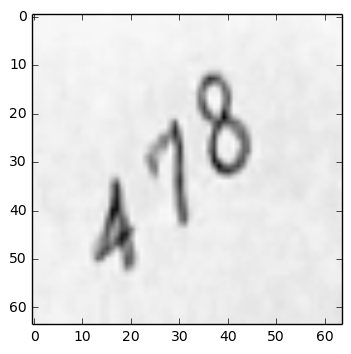

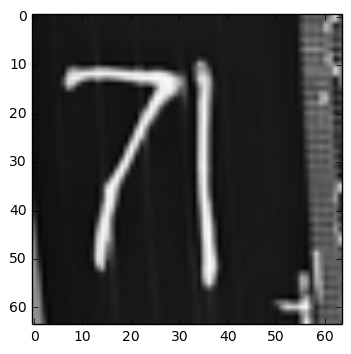

In [78]:
# First two images again
%matplotlib inline  
plt.show(plt.imshow(train_X[0].reshape(img_size, img_size), cmap=plt.cm.Greys))
plt.show(plt.imshow(train_X[1].reshape(img_size, img_size), cmap=plt.cm.Greys))

In [80]:
# Define our performance metric
def accuracy(preds, labels):
    return 100 * np.sum(np.argmax(preds, 2) == np.argmax(labels, 2)) / (preds.shape[0] * preds.shape[1])

Step 0: Loss = 15.15, Training accuracy = 7.20%

Step 100: Loss = 6.39, Training accuracy = 70.04%

Step 200: Loss = 4.61, Training accuracy = 81.48%

Step 300: Loss = 3.54, Training accuracy = 87.36%

Step 400: Loss = 2.81, Training accuracy = 91.52%

Step 500: Loss = 2.28, Training accuracy = 94.04%

Step 600: Loss = 1.88, Training accuracy = 95.88%

Step 700: Loss = 1.57, Training accuracy = 97.20%

Step 800: Loss = 1.32, Training accuracy = 98.08%

Step 900: Loss = 1.12, Training accuracy = 98.68%

Step 1000: Loss = 0.96, Training accuracy = 98.96%



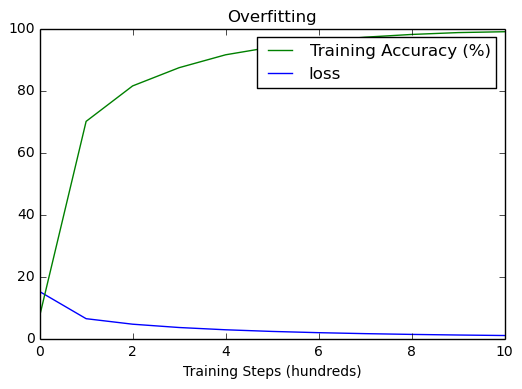

In [81]:
""" LINEAR NEURAL NETWORK """

# Variables
steps_num = 1001
subset = 500
flat_data_size = img_size * img_size * channels_num
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Reshape data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    
    # Data
    train_X_tf = tf.placeholder(tf.float32, (subset, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (subset, digits_num, labels_num))

    # Weights
    weights_1 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_2 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_3 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_4 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_5 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))

    # Biases
    bias_1 = tf.Variable(tf.zeros(labels_num))
    bias_2 = tf.Variable(tf.zeros(labels_num))
    bias_3 = tf.Variable(tf.zeros(labels_num))
    bias_4 = tf.Variable(tf.zeros(labels_num))
    bias_5 = tf.Variable(tf.zeros(labels_num))

    # Model
    def model(data):
        logits_1 = tf.matmul(data, weights_1) + bias_1
        logits_2 = tf.matmul(data, weights_2) + bias_2
        logits_3 = tf.matmul(data, weights_3) + bias_3
        logits_4 = tf.matmul(data, weights_4) + bias_4
        logits_5 = tf.matmul(data, weights_5) + bias_5
        return (logits_1, logits_2, logits_3, logits_4, logits_5)

    # Logits
    (train_logits_1, train_logits_2, train_logits_3, train_logits_4, train_logits_5) = model(train_X_tf)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_5, train_y_tf[:,4,:]))

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_logits_1), 
                          tf.nn.softmax(train_logits_2), 
                          tf.nn.softmax(train_logits_3), 
                          tf.nn.softmax(train_logits_4), 
                          tf.nn.softmax(train_logits_5)), 1)
    
# Session
with tf.device('/gpu:0'):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        # Train
        for i in xrange(steps_num):
            batch_X = train_X_flat[:subset,:]
            batch_y = train_y[:subset,:]
            feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
            _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)

            # Report training accuracy        
            if i % 100 == 0:
                train_accuracy = accuracy(preds, batch_y)
                train_accuracies.append(train_accuracy)
                losses.append(l)
                print('Step %d: Loss = %.2f, Training accuracy = %.2f%%\n' % (i, l, train_accuracy))
    
# Plot training graph to access under/overfitting
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
plt.xlabel('Training Steps (hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('Overfitting')
plt.legend([ta, l], ['Training Accuracy (%)', 'loss'])
plt.show()

Step 100: Loss = 12.74, Training accuracy = 31.88%, Validation accuracy = 36.73%

Step 200: Loss = 10.50, Training accuracy = 42.50%, Validation accuracy = 40.20%

Step 300: Loss = 10.88, Training accuracy = 36.88%, Validation accuracy = 37.51%

Step 400: Loss = 11.04, Training accuracy = 40.62%, Validation accuracy = 42.64%

Step 500: Loss = 9.29, Training accuracy = 50.00%, Validation accuracy = 45.30%

Step 600: Loss = 10.43, Training accuracy = 43.75%, Validation accuracy = 46.58%

Step 700: Loss = 9.67, Training accuracy = 50.62%, Validation accuracy = 48.13%

Step 800: Loss = 9.01, Training accuracy = 50.00%, Validation accuracy = 48.56%

Step 900: Loss = 9.19, Training accuracy = 50.00%, Validation accuracy = 49.60%

Step 1000: Loss = 9.18, Training accuracy = 46.25%, Validation accuracy = 52.64%

Test set accuracy = 53.90%


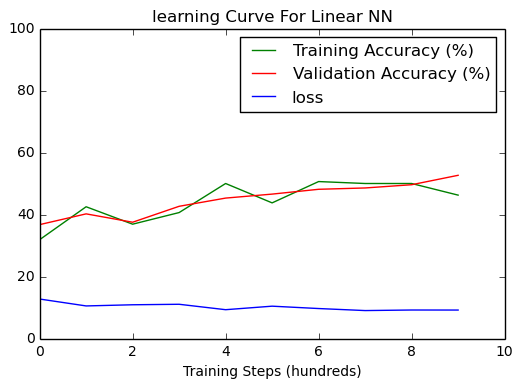

In [83]:
""" LINEAR NEURAL NETWORK """

# Variables
batch_size = 32
reg_constant = 0.001
steps_num = 1001
flat_data_size = img_size * img_size * channels_num
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    
    with tf.name_scope('data') as scope:
        train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size), name='train_X_tf')
        train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num), name='train_y_tf')
        valid_X_tf = tf.constant(valid_X_flat, name='valid_X_tf')
        test_X_tf = tf.constant(test_X_flat, name='test_X_tf')

    # Weights
    with tf.name_scope('weights') as scope:
        weights_1 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_1')
        weights_2 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_2')
        weights_3 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_3')
        weights_4 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_4')
        weights_5 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1), name='weights_5')

    # Biases
    with tf.name_scope('biases') as scope:
        bias_1 = tf.Variable(tf.zeros(labels_num), name='bias_1')
        bias_2 = tf.Variable(tf.zeros(labels_num), name='bias_2')
        bias_3 = tf.Variable(tf.zeros(labels_num), name='bias_3')
        bias_4 = tf.Variable(tf.zeros(labels_num), name='bias_4')
        bias_5 = tf.Variable(tf.zeros(labels_num), name='bias_5')

    # Model
    def model(data):
        logits_1 = tf.matmul(data, weights_1) + bias_1
        logits_2 = tf.matmul(data, weights_2) + bias_2
        logits_3 = tf.matmul(data, weights_3) + bias_3
        logits_4 = tf.matmul(data, weights_4) + bias_4
        logits_5 = tf.matmul(data, weights_5) + bias_5
        return (logits_1, logits_2, logits_3, logits_4, logits_5)

    # Logits
    (train_logits_1, train_logits_2, train_logits_3, train_logits_4, train_logits_5) = model(train_X_tf)
    (valid_logits_1, valid_logits_2, valid_logits_3, valid_logits_4, valid_logits_5) = model(valid_X_tf)
    (test_logits_1, test_logits_2, test_logits_3, test_logits_4, test_logits_5) = model(test_X_tf)
    
    # Loss
    with tf.name_scope('loss') as scope:
        regularization = reg_constant * (tf.nn.l2_loss(weights_1) + 
                                         tf.nn.l2_loss(weights_2) + 
                                         tf.nn.l2_loss(weights_3) + 
                                         tf.nn.l2_loss(weights_4) + 
                                         tf.nn.l2_loss(weights_5))
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits_1, train_y_tf[:,0,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_2, train_y_tf[:,1,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_3, train_y_tf[:,2,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_4, train_y_tf[:,3,:]) + 
                              tf.nn.softmax_cross_entropy_with_logits(train_logits_5, train_y_tf[:,4,:]) + 
                              regularization)

        # Optimizer
        optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_logits_1), 
                          tf.nn.softmax(train_logits_2), 
                          tf.nn.softmax(train_logits_3), 
                          tf.nn.softmax(train_logits_4), 
                          tf.nn.softmax(train_logits_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_logits_1), 
                          tf.nn.softmax(valid_logits_2), 
                          tf.nn.softmax(valid_logits_3), 
                          tf.nn.softmax(valid_logits_4), 
                          tf.nn.softmax(valid_logits_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_logits_1), 
                         tf.nn.softmax(test_logits_2), 
                         tf.nn.softmax(test_logits_3), 
                         tf.nn.softmax(test_logits_4), 
                         tf.nn.softmax(test_logits_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for i in xrange(steps_num):
        # Get batch data and labels
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)
        
        # Report validation accuracy
        if i % 100 == 0 and i != 0:
            train_accuracy = accuracy(preds, batch_y)
            valid_accuracy = accuracy(valid_preds.eval(), valid_y)
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            losses.append(l)
            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))
    
    print('Test set accuracy = %.2f%%' % accuracy(test_preds.eval(), test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Training Steps (hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For Linear NN')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'])
plt.show()

Step 0: Loss = 29.03, Training accuracy = 9.38%, Validation accuracy = 31.36%

Step 100: Loss = 9.19, Training accuracy = 50.62%, Validation accuracy = 59.31%

Step 200: Loss = 7.91, Training accuracy = 49.38%, Validation accuracy = 58.87%

Step 300: Loss = 7.77, Training accuracy = 53.75%, Validation accuracy = 60.10%

Step 400: Loss = 8.10, Training accuracy = 50.00%, Validation accuracy = 60.29%

Step 500: Loss = 7.19, Training accuracy = 56.25%, Validation accuracy = 60.43%

Step 600: Loss = 7.61, Training accuracy = 51.25%, Validation accuracy = 60.36%

Step 700: Loss = 7.55, Training accuracy = 53.75%, Validation accuracy = 60.06%

Step 800: Loss = 7.57, Training accuracy = 51.88%, Validation accuracy = 60.50%

Step 900: Loss = 7.46, Training accuracy = 54.38%, Validation accuracy = 60.51%

Step 1000: Loss = 7.53, Training accuracy = 55.00%, Validation accuracy = 60.56%

Test set accuracy = 64.04%


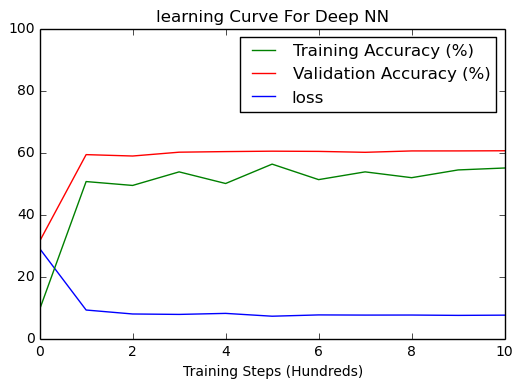

In [84]:
""" DEEP NEURAL NETWORK """

# Hyperparameters
batch_size = 32
reg_constant = 0.001
dropout_rate = 0.5
steps_num = 1001
flat_data_size = img_size * img_size * channels_num
hidden_first_nodes = 1024
hidden_second_nodes = 128
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.constant(valid_X_flat)
    test_X_tf = tf.constant(test_X_flat)

    # First hidden weights
    weights_hidden_first = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))

    # First hidden biases
    biases_hidden_first = tf.Variable(tf.zeros(hidden_first_nodes))
    
    # Second hidden weights
    weights_hidden_second = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))

    # Second hidden biases
    biases_hidden_second = tf.Variable(tf.zeros(hidden_second_nodes))
    
    # Output weights
    weights_output_1 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_2 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_3 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_4 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
    weights_output_5 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))

    # Output biases
    biases_output_1 = tf.Variable(tf.zeros(labels_num))
    biases_output_2 = tf.Variable(tf.zeros(labels_num))
    biases_output_3 = tf.Variable(tf.zeros(labels_num))
    biases_output_4 = tf.Variable(tf.zeros(labels_num))
    biases_output_5 = tf.Variable(tf.zeros(labels_num)) 

    # Model
    def model(data, dropout):
        # Compute first hidden layer
        hidden_first = tf.nn.relu(tf.matmul(data, weights_hidden_first) + biases_hidden_first)
                            
        # Compute second hidden layer
        hidden_second = tf.nn.relu(tf.matmul(hidden_first, weights_hidden_second) + biases_hidden_second)
        
        # Dropout regularization
        if dropout:
            hidden_second = tf.nn.dropout(hidden_second, dropout_rate)
        
        # Compute output layer
        output_1 = tf.matmul(hidden_second, weights_output_1) + biases_output_1
        output_2 = tf.matmul(hidden_second, weights_output_2) + biases_output_2
        output_3 = tf.matmul(hidden_second, weights_output_3) + biases_output_3
        output_4 = tf.matmul(hidden_second, weights_output_4) + biases_output_4
        output_5 = tf.matmul(hidden_second, weights_output_5) + biases_output_5
    
        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Logits
    (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf, True)
    (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf, False)
    (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf, False)
    
    # L2 regularization
    regularization = reg_constant * (tf.nn.l2_loss(weights_output_1) + 
                                     tf.nn.l2_loss(weights_output_2) + 
                                     tf.nn.l2_loss(weights_output_3) + 
                                     tf.nn.l2_loss(weights_output_4) + 
                                     tf.nn.l2_loss(weights_output_5))
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        
        
        # Report validation accuracy
        if i % 100 == 0:
            train_accuracy = accuracy(preds, batch_y)
            valid_accuracy = accuracy(valid_preds.eval(), valid_y)
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)
            losses.append(l)

            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))
        
    print('Test set accuracy = %.2f%%' % accuracy(test_preds.eval(), test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Training Steps (Hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For Deep NN')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'])
plt.show()

Step 0: Loss = 78.74, Training accuracy = 8.12%, Validation accuracy = 60.17%

Step 100: Loss = 19.03, Training accuracy = 54.06%, Validation accuracy = 60.50%

Step 200: Loss = 17.10, Training accuracy = 54.38%, Validation accuracy = 60.58%

Step 300: Loss = 15.61, Training accuracy = 55.31%, Validation accuracy = 60.78%

Step 400: Loss = 13.90, Training accuracy = 58.75%, Validation accuracy = 61.43%

Step 500: Loss = 12.61, Training accuracy = 62.19%, Validation accuracy = 61.53%

Step 600: Loss = 12.10, Training accuracy = 61.88%, Validation accuracy = 61.74%

Step 700: Loss = 11.19, Training accuracy = 64.69%, Validation accuracy = 62.54%

Step 800: Loss = 9.94, Training accuracy = 65.31%, Validation accuracy = 63.57%

Step 900: Loss = 9.85, Training accuracy = 65.31%, Validation accuracy = 63.88%

Step 1000: Loss = 9.18, Training accuracy = 65.94%, Validation accuracy = 63.46%

Test set accuracy = 65.66%


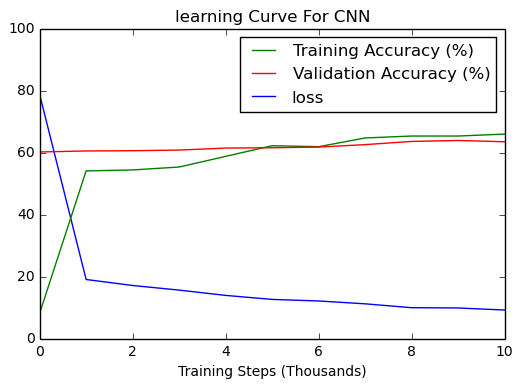

Training and evaluation took 4 minutes


In [106]:
""" CONVOLUTIONAL NEURAL NETWORK 1 """

start = time.time()

# Hyperparameters
steps_num = 1001
batch_size = 64
patch_size = 5
conv_depth_1 = 32
conv_depth_2 = 64
full_nodes = 512
reg_constant = 5e-4
dropout_rate = 0.5
train_accuracies = []
valid_accuracies = []
losses = []
conv_stride = 1
pool_window_size = [1, 2, 2, 1]
pool_stride = [1, 2, 2, 1]
padding = 'SAME'

# Helper functions
def create_weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def create_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def create_conv_layer(data, weights):
    return tf.nn.conv2d(data, weights, [1, conv_stride, conv_stride, 1], padding)

def create_pool_layer(data):
    return tf.nn.max_pool(data, pool_window_size, pool_stride, padding)

def get_conv_shape(data_shape, weights_shape):
    if padding == 'VALID':
        new_height = int(np.ceil((data_shape[1] - weights_shape[0] + 1) / conv_stride))
        new_width = int(np.ceil((data_shape[2] - weights_shape[1] + 1) / conv_stride))
    else:
        new_height = int(np.ceil(data_shape[1] / conv_stride))
        new_width = int(np.ceil(data_shape[2] / conv_stride))
    return (data_shape[0], new_height, new_width, weights_shape[3])

def get_pool_shape(data_shape):
    new_height = int(np.ceil(data_shape[1] / pool_stride[1]))
    new_width = int(np.ceil(data_shape[2] / pool_stride[2]))
    return (data_shape[0], new_height, new_width, data_shape[3])

# Graph
graph = tf.Graph()
with graph.as_default():

    # Data (don't flatten as we did before)
    train_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    valid_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    test_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    test_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))

    # First convolution layer weights
    weights_conv_first = create_weight((patch_size, patch_size, channels_num, conv_depth_1))

    # First convolution layer biases
    biases_conv_first = create_bias((conv_depth_1,))

    # Second convolution layer weights
    weights_conv_second = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))

    # Second convolution layer biases
    biases_conv_second = create_bias((conv_depth_2,))

    # Calculate final pooled layer shape
    conv_first_shape = get_conv_shape(train_X_tf.get_shape().as_list(), weights_conv_first.get_shape().as_list())
    pool_first_shape = get_pool_shape(conv_first_shape)
    conv_second_shape = get_conv_shape(pool_first_shape, weights_conv_second.get_shape().as_list())
    pool_second_shape = get_pool_shape(conv_second_shape)
    final_pooled_flat = pool_second_shape[1] * pool_second_shape[2] * pool_second_shape[3]

    # Fully connected layer weights   
    weights_full = create_weight((final_pooled_flat, full_nodes))

    # Fully connected layer biases
    biases_full = create_bias((full_nodes,))

    # Output weights
    weights_output_1 = create_weight((full_nodes, labels_num))
    weights_output_2 = create_weight((full_nodes, labels_num))
    weights_output_3 = create_weight((full_nodes, labels_num))
    weights_output_4 = create_weight((full_nodes, labels_num))
    weights_output_5 = create_weight((full_nodes, labels_num))

    # Output biases
    biases_output_1 = create_bias((labels_num,))
    biases_output_2 = create_bias((labels_num,))
    biases_output_3 = create_bias((labels_num,))
    biases_output_4 = create_bias((labels_num,))
    biases_output_5 = create_bias((labels_num,)) 

    # Model
    def model(data, dropout):
        # First convolution layer
        conv_first = tf.nn.relu(create_conv_layer(data, weights_conv_first) + biases_conv_first)

        # First pooling layer
        pool_first = create_pool_layer(conv_first)

        # Second convolution layer
        conv_second = tf.nn.relu(create_conv_layer(pool_first, weights_conv_second) + biases_conv_second)

        # Second pooling layer
        pool_second = create_pool_layer(conv_second)

        # Reshape data
        data_size = pool_second.get_shape().as_list()[0]
        pool_second = tf.reshape(pool_second, (data_size, final_pooled_flat))

        # Fully connected layer
        full = tf.nn.relu(tf.matmul(pool_second, weights_full) + biases_full)

        # Dropout regularization (only during training)
        if dropout:
            full = tf.nn.dropout(full, dropout_rate)

        # Output layer
        output_1 = tf.matmul(full, weights_output_1) + biases_output_1
        output_2 = tf.matmul(full, weights_output_2) + biases_output_2
        output_3 = tf.matmul(full, weights_output_3) + biases_output_3
        output_4 = tf.matmul(full, weights_output_4) + biases_output_4
        output_5 = tf.matmul(full, weights_output_5) + biases_output_5

        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Logits
    (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf, True)
    (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf, False)
    (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf, False)

    # L2 regularization (only on fully connected layers)
    regularization = reg_constant * (tf.nn.l2_loss(weights_full) + 
                                     tf.nn.l2_loss(biases_full) + 
                                     tf.nn.l2_loss(weights_output_1) + 
                                     tf.nn.l2_loss(weights_output_2) + 
                                     tf.nn.l2_loss(weights_output_3) + 
                                     tf.nn.l2_loss(weights_output_4) + 
                                     tf.nn.l2_loss(weights_output_5) + 
                                     tf.nn.l2_loss(biases_output_1) + 
                                     tf.nn.l2_loss(biases_output_2) + 
                                     tf.nn.l2_loss(biases_output_3) + 
                                     tf.nn.l2_loss(biases_output_4) + 
                                     tf.nn.l2_loss(biases_output_5))
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X[batch_start:batch_end,:,:,:]
        batch_y = train_y[batch_start:batch_end,:,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        

        # Report validation accuracy
        if i % 100 == 0:
            losses.append(l)
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)

            valid_preds_total = np.ndarray(valid_y.shape)
            for j in xrange(int(np.floor(valid_y.shape[0] / batch_size))):
                batch_start_valid = batch_size * j
                batch_end_valid = batch_start_valid + batch_size
                batch_X_valid = valid_X[batch_start_valid:batch_end_valid,:,:,:]
                batch_y_valid = valid_y[batch_start_valid:batch_end_valid,:,:]                
                feed_dict = {valid_X_tf: batch_X_valid, valid_y_tf: batch_y_valid}
                valid_preds_total[batch_start_valid:batch_end_valid,:,:] = session.run(valid_preds, feed_dict) 

            valid_accuracy = accuracy(valid_preds_total, valid_y)
            valid_accuracies.append(valid_accuracy)            

            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))

    test_preds_total = np.ndarray(test_y.shape)
    for j in xrange(int(np.floor(test_y.shape[0] / batch_size))):
        batch_start_test = batch_size * j
        batch_end_test = batch_start_test + batch_size
        batch_X_test = test_X[batch_start_test:batch_end_test,:,:,:]
        batch_y_test = test_y[batch_start_test:batch_end_test,:,:]                
        feed_dict = {test_X_tf: batch_X_test, test_y_tf: batch_y_test}
        test_preds_total[batch_start_test:batch_end_test,:,:] = session.run(test_preds, feed_dict) 

    print('Test set accuracy = %.2f%%' % accuracy(test_preds_total, test_y))

# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Training Steps (Thousands)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For CNN')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'])
plt.show()

end = time.time()
print('Training and evaluation took %d minutes' % int(np.ceil((end - start) / 60)))

In [110]:
""" CONVOLUTIONAL NEURAL NETWORK 2 """

start = time.time()

# Hyperparameters
steps_num = 1000
batch_size = 64
patch_size = 5
conv_depth_1 = 16
conv_depth_2 = 32
conv_depth_3 = 64
conv_depth_4 = 128
conv_depth_5 = 256
full_nodes = 64
reg_constant = 5e-4
dropout_rate = 0.5
train_accuracies = []
valid_accuracies = []
losses = []
conv_stride = 1
pool_window_size = [1, 2, 2, 1]
pool_stride = [1, 2, 2, 1]
padding = 'SAME'

graph = tf.Graph()
with graph.as_default():

    # Data (don't flatten as we did before)
    train_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    valid_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    test_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    test_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))

    # First convolution layer weights
    weights_conv_1 = create_weight((patch_size, patch_size, channels_num, conv_depth_1))

    # First convolution layer biases
    biases_conv_1 = create_bias((conv_depth_1,))

    # Second convolution layer weights
    weights_conv_2 = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))

    # Second convolution layer biases
    biases_conv_2 = create_bias((conv_depth_2,))
    
    # Third convolution layer weights
    weights_conv_3 = create_weight((patch_size, patch_size, conv_depth_2, conv_depth_3))

    # Third convolution layer biases
    biases_conv_3 = create_bias((conv_depth_3,))

    # Fourth convolution layer weights
    weights_conv_4 = create_weight((patch_size, patch_size, conv_depth_3, conv_depth_4))

    # Fourth convolution layer biases
    biases_conv_4 = create_bias((conv_depth_4,))
    
    # Fifth convolution layer weights
    weights_conv_5 = create_weight((patch_size, patch_size, conv_depth_4, conv_depth_5))

    # Fifth convolution layer biases
    biases_conv_5 = create_bias((conv_depth_5,))
    
    # Calculate final pooled layer shape
    conv_1_shape = get_conv_shape(train_X_tf.get_shape().as_list(), weights_conv_1.get_shape().as_list())
    pool_1_shape = get_pool_shape(conv_1_shape)
    conv_2_shape = get_conv_shape(pool_1_shape, weights_conv_2.get_shape().as_list())
    pool_2_shape = get_pool_shape(conv_2_shape)
    conv_3_shape = get_conv_shape(pool_2_shape, weights_conv_3.get_shape().as_list())
    pool_3_shape = get_pool_shape(conv_3_shape)
    conv_4_shape = get_conv_shape(pool_3_shape, weights_conv_4.get_shape().as_list())
    pool_4_shape = get_pool_shape(conv_4_shape)
    conv_5_shape = get_conv_shape(pool_4_shape, weights_conv_5.get_shape().as_list())
    pool_5_shape = get_pool_shape(conv_5_shape)
    final_pooled_flat = pool_5_shape[1] * pool_5_shape[2] * pool_5_shape[3]

    # First fully connected layer weights   
    weights_full = create_weight((final_pooled_flat, full_nodes))

    # First fully connected layer biases
    biases_full = create_bias((full_nodes,))

    # Output weights
    weights_output_1 = create_weight((full_nodes, labels_num))
    weights_output_2 = create_weight((full_nodes, labels_num))
    weights_output_3 = create_weight((full_nodes, labels_num))
    weights_output_4 = create_weight((full_nodes, labels_num))
    weights_output_5 = create_weight((full_nodes, labels_num))

    # Output biases
    biases_output_1 = create_bias((labels_num,))
    biases_output_2 = create_bias((labels_num,))
    biases_output_3 = create_bias((labels_num,))
    biases_output_4 = create_bias((labels_num,))
    biases_output_5 = create_bias((labels_num,)) 

    # Model
    def model(data, dropout):
        # First convolution layer
        conv_1_1 = tf.nn.relu(create_conv_layer(data, weights_conv_1) + biases_conv_1)
        conv_1_2 = tf.nn.relu(create_conv_layer(conv_1_1, weights_conv_2) + biases_conv_2)
        pool_1 = create_pool_layer(conv_1_2)

        # Second convolution layer
        conv_2_1 = tf.nn.relu(create_conv_layer(pool_1, weights_conv_2) + biases_conv_2)
        conv_2_2 = tf.nn.relu(create_conv_layer(conv_2_1, weights_conv_2) + biases_conv_2)
        pool_2 = create_pool_layer(conv_2_2)

        # Third convolution layer
        conv_3_1 = tf.nn.relu(create_conv_layer(pool_2, weights_conv_3) + biases_conv_3)
        conv_3_2 = tf.nn.relu(create_conv_layer(conv_3_1, weights_conv_3) + biases_conv_3)
        pool_3 = create_pool_layer(conv_3_2)
        
        # Fourth convolution layer
        conv_4_1 = tf.nn.relu(create_conv_layer(pool_3, weights_conv_4) + biases_conv_4)
        conv_4_2 = tf.nn.relu(create_conv_layer(conv_4_2, weights_conv_4) + biases_conv_4)
        pool_4 = create_pool_layer(conv_4_2)
        
        # Fifth convolution layer
        conv_5_1 = tf.nn.relu(create_conv_layer(pool_4, weights_conv_5) + biases_conv_5)
        conv_5_2 = tf.nn.relu(create_conv_layer(conv_4_2, weights_conv_5) + biases_conv_5)
        pool_5 = create_pool_layer(conv_5_2)

        # Reshape data
        data_size = pool_5.get_shape().as_list()[0]
        reshaped = tf.reshape(pool_5, (data_size, final_pooled_flat))

        # First fully connected layer
        full = tf.nn.relu(tf.matmul(reshaped, weights_full) + biases_full)

        # Dropout regularization and output layer
        if dropout:
            full_dropped = tf.nn.dropout(full, dropout_rate)
            output_1 = tf.matmul(full_dropped, weights_output_1) + biases_output_1
            output_2 = tf.matmul(full_dropped, weights_output_2) + biases_output_2
            output_3 = tf.matmul(full_dropped, weights_output_3) + biases_output_3
            output_4 = tf.matmul(full_dropped, weights_output_4) + biases_output_4
            output_5 = tf.matmul(full_dropped, weights_output_5) + biases_output_5
        else:
            output_1 = tf.matmul(full, weights_output_1) + biases_output_1
            output_2 = tf.matmul(full, weights_output_2) + biases_output_2
            output_3 = tf.matmul(full, weights_output_3) + biases_output_3
            output_4 = tf.matmul(full, weights_output_4) + biases_output_4
            output_5 = tf.matmul(full, weights_output_5) + biases_output_5

        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Logits
    (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf, True)
    (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf, False)
    (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf, False)

    # L2 regularization (only on fully connected layers)
    regularization = reg_constant * (tf.nn.l2_loss(weights_full) + 
                                     tf.nn.l2_loss(biases_full) +
                                     tf.nn.l2_loss(weights_output_1) + 
                                     tf.nn.l2_loss(weights_output_2) + 
                                     tf.nn.l2_loss(weights_output_3) + 
                                     tf.nn.l2_loss(weights_output_4) + 
                                     tf.nn.l2_loss(weights_output_5) + 
                                     tf.nn.l2_loss(biases_output_1) + 
                                     tf.nn.l2_loss(biases_output_2) + 
                                     tf.nn.l2_loss(biases_output_3) + 
                                     tf.nn.l2_loss(biases_output_4) + 
                                     tf.nn.l2_loss(biases_output_5))
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)
    
# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X[batch_start:batch_end,:,:,:]
        batch_y = train_y[batch_start:batch_end,:,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        

        # Report validation accuracy
        if i % 100 == 0:
            losses.append(l)
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)

            valid_preds_total = np.ndarray(valid_y.shape)
            for j in xrange(int(np.floor(valid_y.shape[0] / batch_size))):
                batch_start_valid = batch_size * j
                batch_end_valid = batch_start_valid + batch_size
                batch_X_valid = valid_X[batch_start_valid:batch_end_valid,:,:,:]
                batch_y_valid = valid_y[batch_start_valid:batch_end_valid,:,:]                
                feed_dict = {valid_X_tf: batch_X_valid, valid_y_tf: batch_y_valid}
                valid_preds_total[batch_start_valid:batch_end_valid,:,:] = session.run(valid_preds, feed_dict) 

            valid_accuracy = accuracy(valid_preds_total, valid_y)
            valid_accuracies.append(valid_accuracy)            

            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))

    test_preds_total = np.ndarray(test_y.shape)
    for j in xrange(int(np.floor(test_y.shape[0] / batch_size))):
        batch_start_test = batch_size * j
        batch_end_test = batch_start_test + batch_size
        batch_X_test = test_X[batch_start_test:batch_end_test,:,:,:]
        batch_y_test = test_y[batch_start_test:batch_end_test,:,:]                
        feed_dict = {test_X_tf: batch_X_test, test_y_tf: batch_y_test}
        test_preds_total[batch_start_test:batch_end_test,:,:] = session.run(test_preds, feed_dict) 

    print('Test set accuracy = %.2f%%' % accuracy(test_preds_total, test_y))

# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Training Steps (Thousands)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For CNN')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'])
plt.show()

end = time.time()
print('Training and evaluation took %d minutes' % int(np.ceil((end - start) / 60)))

ValueError: Dimensions 32 and 16 are not compatible